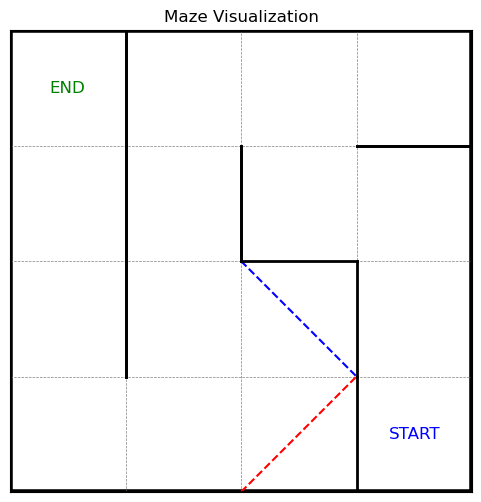

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from enum import Enum
from typing import List

class SideWall(Enum):
    NONE = 0
    WALL = 1

class InternalWall(Enum):
    NONE = 0
    RIGHT_SLASH = '/'   # Diagonal /
    LEFT_SLASH = '\\'   # Diagonal \

class Cell:
    def __init__(self):
        self.side_walls = {
            'top': SideWall.NONE,
            'right': SideWall.NONE,
            'bottom': SideWall.NONE,
            'left': SideWall.NONE,
        }
        self.internal_wall: InternalWall = InternalWall.NONE

    def set_side_wall(self, direction: str):
        if direction in self.side_walls:
            self.side_walls[direction] = SideWall.WALL

    def set_internal_wall(self, wall_type: InternalWall):
        self.internal_wall = wall_type

class Maze:
    def __init__(self, width: int = 4, height: int = 4):
        self.width = width
        self.height = height
        self.grid: List[List[Cell]] = [
            [Cell() for _ in range(width)] for _ in range(height)
        ]

    def set_side_wall(self, x: int, y: int, direction: str):
        self.grid[y][x].set_side_wall(direction)
    
    def set_side_walls(self, x: int, y: int, walls: List[str]):
        for wall in walls:
            self.set_side_wall(x, y, wall)

    def set_internal_wall(self, x: int, y: int, wall_type: InternalWall):
        self.grid[y][x].set_internal_wall(wall_type)

    def get_cell(self, x: int, y: int) -> Cell:
        return self.grid[y][x]
    
    def __str__(self):
        maze_str = ""
        # Print maze walls with coordinates
        for y in range(self.height):
            for x in range(self.width):
                cell = self.grid[y][x]
                maze_str += f"Cell({x}, {y}): "
                maze_str += f"Top: {cell.side_walls['top'].name}, "
                maze_str += f"Right: {cell.side_walls['right'].name}, "
                maze_str += f"Bottom: {cell.side_walls['bottom'].name}, "
                maze_str += f"Left: {cell.side_walls['left'].name}, "
                maze_str += f"Internal: {cell.internal_wall.name}\n"
        return maze_str
    
maze = Maze()

maze.set_side_walls(0, 0, ['left', 'right'])
maze.set_side_walls(0, 1, ['left', 'right'])
maze.set_side_walls(0, 2, ['top', 'right'])
maze.set_side_walls(0, 3, ['top', 'bottom', 'right'])
maze.set_internal_wall(1, 0, InternalWall.RIGHT_SLASH)
maze.set_internal_wall(1, 1, InternalWall.LEFT_SLASH)
maze.set_side_walls(1, 2, ['left', 'bottom'])
maze.set_side_walls(1, 3, ['top'])
maze.set_side_walls(2, 0, ['bottom'])
maze.set_side_walls(2, 1, ['left'])
maze.set_side_walls(2, 2, ['right', 'left'])
maze.set_side_walls(2, 3, ['top', 'left'])
maze.set_side_walls(3, 0, ['left', 'bottom'])
maze.set_side_walls(3, 1, ['right', 'left'])
maze.set_side_walls(3, 2, ['right', 'left'])
maze.set_side_walls(3, 3, ['right', 'left'])    
    
# Plotting the maze
def plot_maze(maze: Maze):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, maze.width)
    ax.set_ylim(0, maze.height)
    ax.set_aspect('equal')
    ax.set_xticks(range(maze.width + 1))
    ax.set_yticks(range(maze.height + 1))
    ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    for y in range(maze.height):
        for x in range(maze.width):
            cell = maze.get_cell(x, y)
            x0, y0 = maze.width - x - 1, y  # Flip y for display

            # Draw side walls
            if cell.side_walls['top'] == SideWall.WALL:
                ax.plot([x0, x0 + 1], [y0 + 1, y0 + 1], 'k-', lw=2)
            if cell.side_walls['right'] == SideWall.WALL:
                ax.plot([x0 + 1, x0 + 1], [y0, y0 + 1], 'k-', lw=2)
            if cell.side_walls['bottom'] == SideWall.WALL:
                ax.plot([x0, x0 + 1], [y0, y0], 'k-', lw=2)
            if cell.side_walls['left'] == SideWall.WALL:
                ax.plot([x0, x0], [y0, y0 + 1], 'k-', lw=2)

            # Draw internal wall
            if cell.internal_wall == InternalWall.RIGHT_SLASH:
                ax.plot([x0, x0 + 1], [y0, y0 + 1], 'r--', lw=1.5)
            elif cell.internal_wall == InternalWall.LEFT_SLASH:
                ax.plot([x0, x0 + 1], [y0 + 1, y0], 'b--', lw=1.5)

    # Mark start and end
    ax.text(0.5, maze.height - 0.5, "END", color='green', ha='center', va='center', fontsize=12)
    ax.text(maze.width - 0.5, 0.5, "START", color='blue', ha='center', va='center', fontsize=12)

    maze_border = patches.Rectangle(
        (0, 0), maze.width, maze.height,
        linewidth=4, edgecolor='black', facecolor='none'
        )
    ax.add_patch(maze_border)

    plt.title("Maze Visualization")
    plt.show()

plot_maze(maze)

In [19]:
from collections import deque

def bfs(maze: Maze, start=(0, 0), end=(3, 3)):
    queue = deque()
    queue.append((start, [start]))  # (current_position, path_so_far)
    visited = set()
    visited.add(start)

    # Coordinate shifts based on your maze orientation:
    directions = {
        'top': (0, 1),     # move up (increase y)
        'left': (1, 0),    # move left (increase x)
        'right': (-1, 0),  # move right (decrease x)
        'bottom': (0, -1), # move down (decrease y)
    }

    while queue:
        (x, y), path = queue.popleft()

        if (x, y) == end:
            return path  # Found the path

        for direction, (dx, dy) in directions.items():
            nx, ny = x + dx, y + dy

            if 0 <= nx < maze.width and 0 <= ny < maze.height:
                if (nx, ny) not in visited:
                    if not wall_exists(x, y, direction, maze):
                        queue.append(((nx, ny), path + [(nx, ny)]))
                        visited.add((nx, ny))

    return None  # No path found

def wall_exists(x: int, y: int, direction: str, maze: Maze) -> bool:
    # Out of bounds check
    if (direction == 'top' and y == maze.height - 1) or \
       (direction == 'bottom' and y == 0) or \
       (direction == 'left' and x == maze.width - 1) or \
       (direction == 'right' and x == 0):
        return True  # Can't move out of bounds

    current_cell = maze.get_cell(x, y)

    # Check if there's a side wall in the current cell
    if current_cell.side_walls[direction] == SideWall.WALL:
        return True

    # Compute neighbor coordinates
    directions = {
        'top': (0, 1),
        'right': (-1, 0),
        'bottom': (0, -1),
        'left': (1, 0)
    }
    dx, dy = directions[direction]
    nx, ny = x + dx, y + dy

    # Check diagonal wall in the neighbor cell
    if 0 <= nx < maze.width and 0 <= ny < maze.height:
        neighbor = maze.get_cell(nx, ny)
        diag = neighbor.internal_wall

        if diag != InternalWall.NONE:
            return True

    return False  # No wall blocking


In [20]:
path = bfs(maze)

if path:
    print("Path found:")
    for step in path:
        print(step)
else:
    print("No path found.")


Path found:
(0, 0)
(0, 1)
(0, 2)
(1, 2)
(1, 3)
(2, 3)
(2, 2)
(2, 1)
(2, 0)
(3, 0)
(3, 1)
(3, 2)
(3, 3)


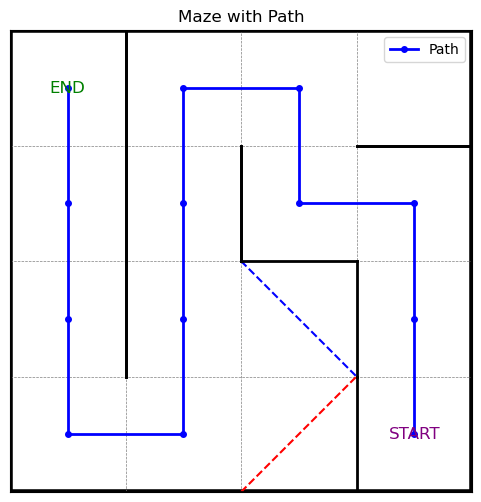

In [28]:
from typing import Tuple

def plot_maze(maze: Maze, path: List[Tuple[int, int]] = None):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, maze.width)
    ax.set_ylim(0, maze.height)
    ax.set_aspect('equal')
    ax.set_xticks(range(maze.width + 1))
    ax.set_yticks(range(maze.height + 1))
    ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    for y in range(maze.height):
        for x in range(maze.width):
            cell = maze.get_cell(x, y)
            x0, y0 = maze.width - x - 1, y  # Flip x for display (0,0 bottom-right)

            # Draw side walls
            if cell.side_walls['top'] == SideWall.WALL:
                ax.plot([x0, x0 + 1], [y0 + 1, y0 + 1], 'k-', lw=2)
            if cell.side_walls['right'] == SideWall.WALL:
                ax.plot([x0 + 1, x0 + 1], [y0, y0 + 1], 'k-', lw=2)
            if cell.side_walls['bottom'] == SideWall.WALL:
                ax.plot([x0, x0 + 1], [y0, y0], 'k-', lw=2)
            if cell.side_walls['left'] == SideWall.WALL:
                ax.plot([x0, x0], [y0, y0 + 1], 'k-', lw=2)

            # Draw internal wall
            if cell.internal_wall == InternalWall.RIGHT_SLASH:
                ax.plot([x0, x0 + 1], [y0, y0 + 1], 'r--', lw=1.5)
            elif cell.internal_wall == InternalWall.LEFT_SLASH:
                ax.plot([x0, x0 + 1], [y0 + 1, y0], 'b--', lw=1.5)

    # Draw path if given
    if path:
        path_x = [maze.width - x - 0.5 for x, y in path]
        path_y = [y + 0.5 for x, y in path]
      
        ax.plot(path_x, path_y, 'o-', color='blue', linewidth=2, markersize=4, label='Path')

    # Mark start and end
    ax.text(0.5, maze.height - 0.5, "END", color='green', ha='center', va='center', fontsize=12)
    ax.text(maze.width - 0.5, 0.5, "START", color='purple', ha='center', va='center', fontsize=12)

    # Bold outer border
    maze_border = patches.Rectangle(
        (0, 0), maze.width, maze.height,
        linewidth=4, edgecolor='black', facecolor='none'
    )
    ax.add_patch(maze_border)

    plt.title("Maze with Path")
    plt.legend()
    plt.show()

plot_maze(maze, path)